In [5]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import matplotlib.pyplot as plt
import sys
import pdb
import glob
import pickle
import dill

import sys
sys.path.append('/home/jyotika/Utils/hddm/')

import hddm

data_dir = "./Data/Y_maze/Decision_times/"
data_target_dir = "./Data/processed_data/Y_maze/"
figure_dir = "./Figures/Y_maze/"

plt.rcParams["figure.facecolor"] = "w"

In [6]:
all_conflicts = pd.read_csv(data_target_dir+"all_experiments_df_with_DTs.csv")

In [12]:
def generate_trialwise_estimates(behavioral_features, av_beta_intercept_df):
    n = len(behavioral_features)
    ind0 = np.where(behavioral_features["response"]==0.0)[0]
    ind1 = np.where(behavioral_features["response"]==1.0)[0]
    
    v_mean_intercept0 = av_beta_intercept_df.v_Intercept.mean()
    v_mean_intercept1 = av_beta_intercept_df["v_C(response)[T.1.0]"].mean()
    
    #a_mean_intercept = av_beta_intercept_df.a_Intercept.mean()
    
    #rt_mean_beta_response0 = av_beta_intercept_df["v_rt:C(response)[0.0]"].mean()
    rt_mean_beta = av_beta_intercept_df["v_rt"].mean()
    
    #accuracy_mean_beta = av_beta_intercept_df.v_accuracy.mean()
    v_jittered_intercept0 = av_beta_intercept_df.v_Intercept.sample(n).reset_index(drop=True)
    v_jittered_intercept1 = av_beta_intercept_df["v_C(response)[T.1.0]"].sample(n).reset_index(drop=True)
    
    
    
#     rt_jittered_beta_response0 =  av_beta_intercept_df["v_rt:C(response)[0.0]"].sample(n).reset_index(drop=True) 
#     rt_jittered_beta_response1 =  av_beta_intercept_df["v_rt:C(response)[1.0]"].sample(n).reset_index(drop=True) 
    rt_jittered_beta =  av_beta_intercept_df["v_rt"].sample(n).reset_index(drop=True) 
        
    print("v_jittered_intercept0",v_jittered_intercept0)
    print("rt_jittered_beta",rt_jittered_beta)
    
#     print("rt_jittered_beta0",rt_jittered_beta_response0)
#     print("rt_jittered_beta1",rt_jittered_beta_response1)
    
    rt = behavioral_features.rt; #accuracy = behavioral_features.accuracy

    #a_trialwise_estimate = a_mean_intercept + aCPP_mean_beta * cpp
    v_trialwise_estimate = [v_mean_intercept0 + rt_mean_beta * np.array(rt)[i] if x ==0 else v_mean_intercept1 + rt_mean_beta * np.array(rt)[i]    for i,x in enumerate(behavioral_features.response)]


    #a_trialwise_estimate_jittered = a_jittered_intercept + aCPP_jittered_beta * cpp
    v_trialwise_estimate_jittered = [np.array(v_jittered_intercept0)[i] + np.array(rt_jittered_beta)[i] * np.array(rt)[i] if x == 0 else np.array(v_jittered_intercept1)[i] + np.array(rt_jittered_beta)[i] * np.array(rt)[i]  for i,x in enumerate(behavioral_features.response)]

    behavioral_features['v_est'] = v_trialwise_estimate
    behavioral_features['v_est_jittered'] = v_trialwise_estimate_jittered
    behavioral_features['slope(v_vs_rt)'] = rt_mean_beta
    behavioral_features['v_jittered_intercept0'] = v_jittered_intercept0
    behavioral_features['v_jittered_intercept1'] = v_jittered_intercept1
    
    return behavioral_features
    

In [13]:
model_dicts = dict()
models = dict()
for grp in all_conflicts.groupby(["conflict + volatility"]):

    hddm_data = grp[1].copy()
    hddm_data["RT(ms)"] = hddm_data["RT(ms)"]/1000.
    hddm_data = hddm_data.rename(columns={'optimal_action':'response','RT(ms)':'rt'})
        
    m = hddm.HDDMRegressor(hddm_data,('v ~ rt + C(response)'),p_outlier=0.05)
    m.find_starting_values()
    m.sample(10000, burn=1000,dbname='v_rt',db='pickle')
    
    hddm_data = generate_trialwise_estimates(hddm_data, m.get_traces())
    model_dicts[grp[0]] = hddm_data.copy()
    models[grp[0]+"_model"] = m
    print(hddm_data)


No model attribute --> setting up standard HDDM
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rt + C(response)', 'params': ['v_Intercept', 'v_C(response)[T.1.0]', 'v_rt'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fdb3f270790>}
Uses Identity Link
177.03180411088806
177.03374274160032
 [-----------------100%-----------------] 10001 of 10000 complete in 2203.0 secv_jittered_intercept0 0      -6.554941
1      -6.501141
2      -6.487316
3      -6.507463
4      -6.480595
          ...   
5551   -6.594020
5552   -6.479336
5553   -6.494681
5554   -6.576851
5555   -6.665048
Name: v_Intercept, Length: 5556, dtype: float64
rt_jittered_beta 0      -3.859390
1      -4.048908
2      -3.807790
3      -3.834032
4      -3.928489
          ...   
5551   -3.763943
5552   -3.806814
5553   -3.883224
5554   -3.838894
5555   -3.989805
Name: v_rt, Length: 5556, dtype: float64
       Unnamed: 0  level_0  index conflict condition volatility  event_marker  \
6013         60

-511.45786032887213
-511.457665340811
 [-----------------100%-----------------] 10001 of 10000 complete in 1592.8 secv_jittered_intercept0 0      -6.253559
1      -6.278069
2      -6.372101
3      -6.227430
4      -6.299577
          ...   
6008   -6.493013
6009   -6.123200
6010   -6.380095
6011   -6.375747
6012   -6.326417
Name: v_Intercept, Length: 6013, dtype: float64
rt_jittered_beta 0      -3.671256
1      -3.684837
2      -3.645888
3      -3.792163
4      -3.746335
          ...   
6008   -3.734188
6009   -3.665538
6010   -3.748969
6011   -3.658265
6012   -3.666624
Name: v_rt, Length: 6013, dtype: float64
      Unnamed: 0  level_0  index conflict condition volatility  event_marker  \
0              0        0      0      Low   Control       High             8   
1              1        1      1      Low   Control       High             8   
2              2        2      2      Low   Control       High             1   
3              3        3      3      Low   Control       Hig

No model attribute --> setting up standard HDDM
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rt + C(response)', 'params': ['v_Intercept', 'v_C(response)[T.1.0]', 'v_rt'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fdb3f05f310>}
Uses Identity Link
6.14978747740863
6.149787610681418
 [-----------------100%-----------------] 10000 of 10000 complete in 1233.5 secv_jittered_intercept0 0      -6.137632
1      -6.341030
2      -6.255337
3      -6.420830
4      -6.174472
          ...   
5475   -6.165173
5476   -6.414965
5477   -6.136752
5478   -6.293779
5479   -6.275284
Name: v_Intercept, Length: 5480, dtype: float64
rt_jittered_beta 0      -3.759459
1      -3.641136
2      -3.565662
3      -3.507986
4      -3.747278
          ...   
5475   -3.510674
5476   -3.513135
5477   -3.589073
5478   -3.594229
5479   -3.680764
Name: v_rt, Length: 5480, dtype: float64
       Unnamed: 0  level_0  index conflict condition volatility  event_marker  \
33050       33050 

In [14]:
# hddm_data = grp[1].copy()
# hddm_data["RT(ms)"] = hddm_data["RT(ms)"]/1000.
# hddm_data = hddm_data.rename(columns={'optimal_action':'response','RT(ms)':'rt'})
        
# m = hddm.HDDMRegressor(hddm_data,('v ~ rt + C(response)'),p_outlier=0.05)


In [15]:
hddm_data['rt'].min()

0.11

In [16]:
# m.find_starting_values()
# m.sample(10000, burn=1000,dbname='v_rt',db='pickle')


In [17]:
# hddm_data = generate_trialwise_estimates(hddm_data, m.get_traces())

In [18]:
# models = dict()
# model_dicts[grp[0]] = hddm_data.copy()
# models[grp[0]+"_model"] = m


In [19]:
pickle.dump(model_dicts,open(data_target_dir+"model_dict_DDM_vs_behavioral_features.pickle","wb"))


In [22]:
dill.dump(models,open(data_target_dir+"models_DDM_vs_behavioral_features.pickle","wb"))

In [23]:
model_dicts = pickle.load(open(data_target_dir+"model_dict_DDM_vs_behavioral_features.pickle","rb"))

In [24]:
model_dicts['High - High']

,Unnamed: 0,level_0,index,conflict,condition,volatility,event_marker,block,reward_probability,trial_length_range,...,chosen_action,rewarded,response,rt,conflict + volatility,v_est,v_est_jittered,slope(v_vs_rt),v_jittered_intercept0,v_jittered_intercept1
6013,6013,0,0,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,0.299,High - High,-7.666196,-7.708899,-3.886055,NaN,NaN
6014,6014,1,1,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,0.413,High - High,-8.109206,-8.173340,-3.886055,NaN,NaN
6015,6015,2,2,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,0.942,High - High,-10.164929,-10.074255,-3.886055,NaN,NaN
6016,6016,3,3,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,0.417,High - High,-8.124751,-8.106254,-3.886055,NaN,NaN
6017,6017,4,4,High,Control,High,1,left,25-75,10-20,...,left,rewarded,1.0,1.250,High - High,8.123571,8.066603,-3.886055,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11564,11564,5551,8341,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,1.933,High - High,-14.016010,-13.869722,-3.886055,NaN,NaN
11565,11565,5552,8342,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,0.450,High - High,-8.252990,-8.192402,-3.886055,NaN,NaN
11566,11566,5553,8343,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,1.122,High - High,-10.864419,-10.851658,-3.886055,NaN,NaN
11567,11567,5554,8344,High,Control,High,8,left,25-75,10-20,...,right,unrewarded,0.0,0.504,High - High,-8.462837,-8.511654,-3.886055,NaN,NaN


In [63]:
all_rts_vs_drift = pd.DataFrame()

for k in model_dicts.keys():
    print(k)
    if "model" in k:
        continue
    df = model_dicts[k]
    all_rts_vs_drift = all_rts_vs_drift.append(df)
all_rts_vs_drift["volatility + response"] = [x+"-"+str(y)  for x,y in zip(all_rts_vs_drift["volatility"],all_rts_vs_drift["response"])]
all_rts_vs_drift["abs(v_est_jittered)"] = np.abs(all_rts_vs_drift["v_est_jittered"])
all_rts_vs_drift.to_csv(data_target_dir+"all_rts_vs_drift.csv")

High - High
High - Low
Low - High
Low - Low
No - High
No - Low


In [60]:
all_rts_vs_drift

,Unnamed: 0,level_0,index,conflict,condition,volatility,event_marker,block,reward_probability,trial_length_range,...,rewarded,response,rt,conflict + volatility,v_est,v_est_jittered,slope(v_vs_rt),v_jittered_intercept0,v_jittered_intercept1,volatility + response
6013,6013,0,0,High,Control,High,8,left,25-75,10-20,...,unrewarded,0.0,0.299,High - High,-7.666196,-7.708899,-3.886055,NaN,NaN,High-0.0
6014,6014,1,1,High,Control,High,8,left,25-75,10-20,...,unrewarded,0.0,0.413,High - High,-8.109206,-8.173340,-3.886055,NaN,NaN,High-0.0
6015,6015,2,2,High,Control,High,8,left,25-75,10-20,...,unrewarded,0.0,0.942,High - High,-10.164929,-10.074255,-3.886055,NaN,NaN,High-0.0
6016,6016,3,3,High,Control,High,8,left,25-75,10-20,...,unrewarded,0.0,0.417,High - High,-8.124751,-8.106254,-3.886055,NaN,NaN,High-0.0
6017,6017,4,4,High,Control,High,1,left,25-75,10-20,...,rewarded,1.0,1.250,High - High,8.123571,8.066603,-3.886055,NaN,NaN,High-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33045,33045,7501,10526,No,Control,Low,5,right,0-90,20-30,...,rewarded,1.0,0.455,No - Low,6.739875,6.630928,-1.095986,NaN,NaN,Low-1.0
33046,33046,7502,10527,No,Control,Low,5,right,0-90,20-30,...,rewarded,1.0,0.385,No - Low,6.816594,6.848748,-1.095986,NaN,NaN,Low-1.0
33047,33047,7503,10528,No,Control,Low,5,right,0-90,20-30,...,rewarded,1.0,0.440,No - Low,6.756314,6.700776,-1.095986,NaN,NaN,Low-1.0
33048,33048,7504,10529,No,Control,Low,5,right,0-90,20-30,...,rewarded,1.0,1.169,No - Low,5.957341,5.977618,-1.095986,NaN,NaN,Low-1.0


/home/jyotika/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/jyotika/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


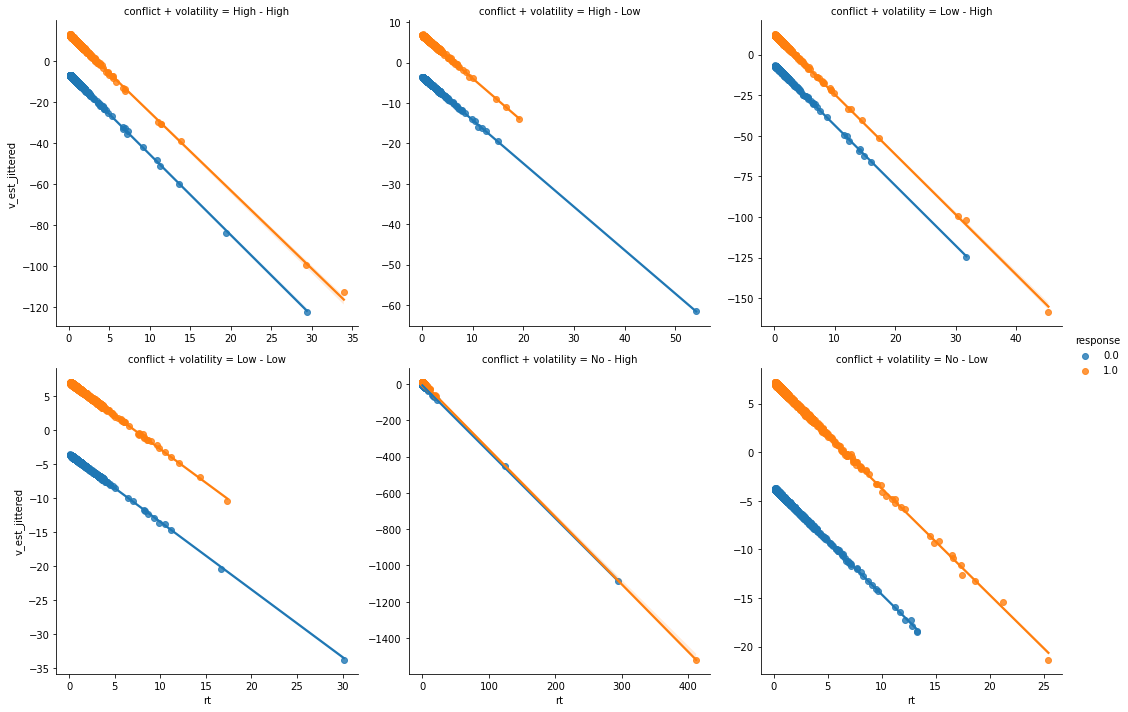

In [28]:
g1 = sns.lmplot(x="rt",y="v_est_jittered",data=all_rts_vs_drift,hue="response",col="conflict + volatility",col_wrap=3,sharey=False,sharex=False)
g1.savefig(figure_dir+"vest_jittered_vs_rt_all.png")

/home/jyotika/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/jyotika/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


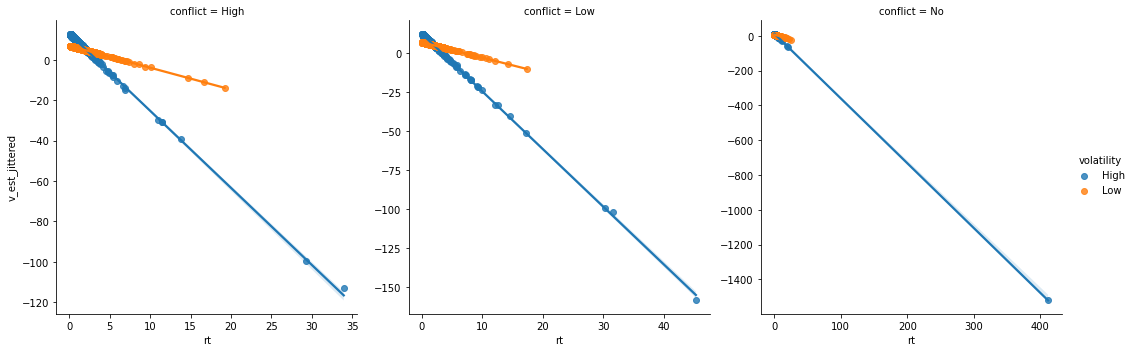

In [32]:
g2 = sns.lmplot(x="rt",y="v_est_jittered",data=all_rts_vs_drift.loc[all_rts_vs_drift["response"]==1.0],hue="volatility",col="conflict",col_wrap=3,sharex=False,sharey=False)
g2.savefig(figure_dir+"vest_jittered_vs_rt_optimal_actions.png")


/home/jyotika/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/jyotika/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


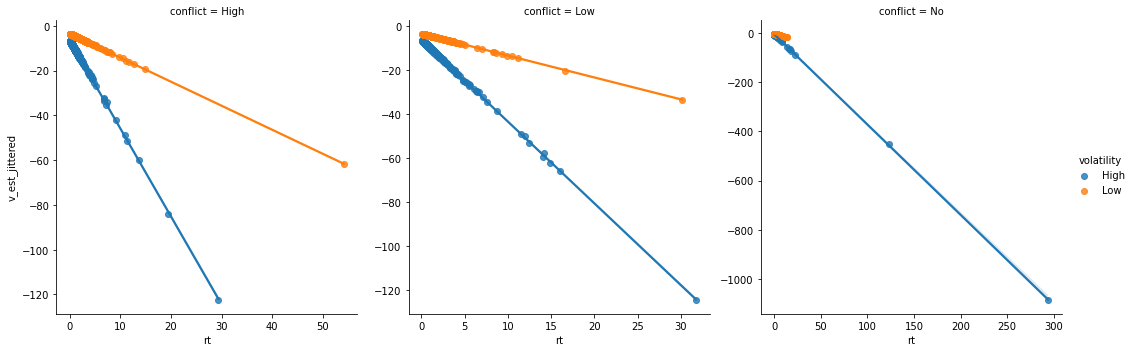

In [33]:
g2 = sns.lmplot(x="rt",y="v_est_jittered",data=all_rts_vs_drift.loc[all_rts_vs_drift["response"]==0.0],hue="volatility",col="conflict",col_wrap=3,sharex=False,sharey=False)
g2.savefig(figure_dir+"vest_jittered_vs_rt_sub_optimal_actions.png")


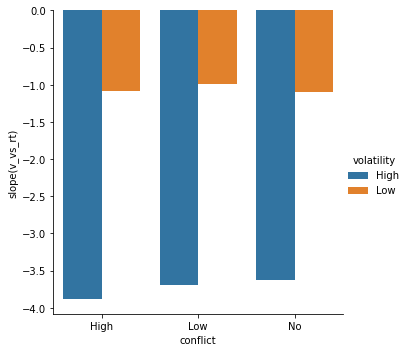

In [36]:
g3 = sns.catplot(x="conflict",y='slope(v_vs_rt)',data=all_rts_vs_drift,hue="volatility",kind='bar')
g3.savefig(figure_dir+"Slope_v_vs_rt_all.png")

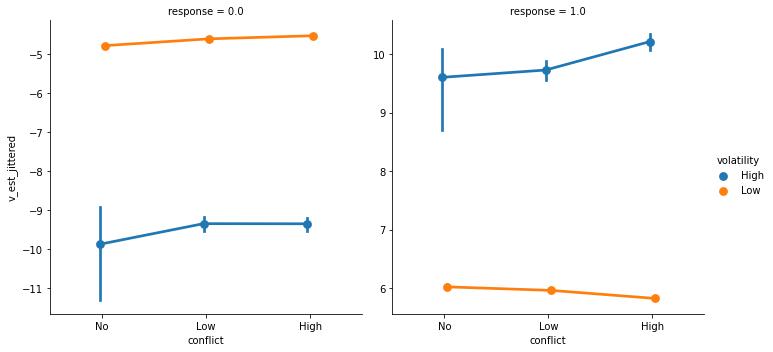

In [47]:
g3 = sns.catplot(x="conflict",y='v_est_jittered',data=all_rts_vs_drift,hue="volatility",kind='point',dodge=True,order=["No","Low","High"],col='response',sharey=False)
g3.savefig(figure_dir+"v_est_jittered_all.png")

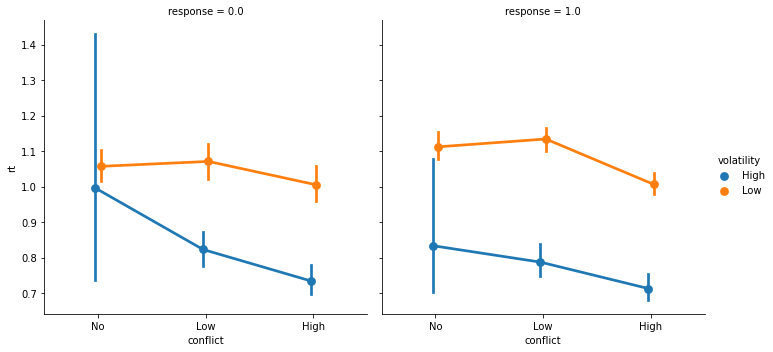

In [49]:
g4 = sns.catplot(x="conflict",y='rt',data=all_rts_vs_drift,hue="volatility",kind='point',dodge=True,order=["No","Low","High"],col='response')
g4.savefig(figure_dir+"reaction_times_all.png")

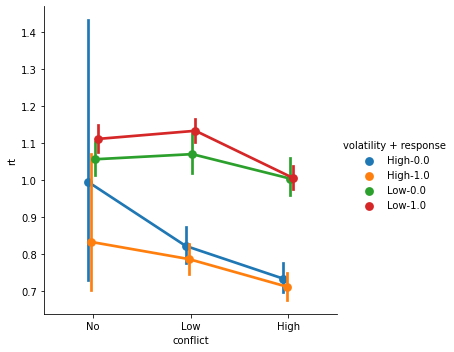

In [61]:

g5 = sns.catplot(x="conflict",y='rt',data=all_rts_vs_drift,hue="volatility + response",kind='point',dodge=True,order=["No","Low","High"])
g5.savefig(figure_dir+"reaction_times_all_response_wise.png")

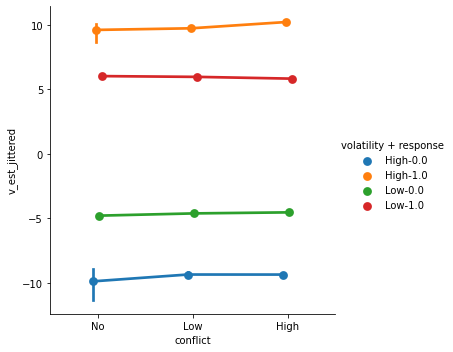

In [62]:
g5 = sns.catplot(x="conflict",y='v_est_jittered',data=all_rts_vs_drift,hue="volatility + response",kind='point',dodge=True,order=["No","Low","High"])
g5.savefig(figure_dir+"v_est_jittered_all_response_wise.png")

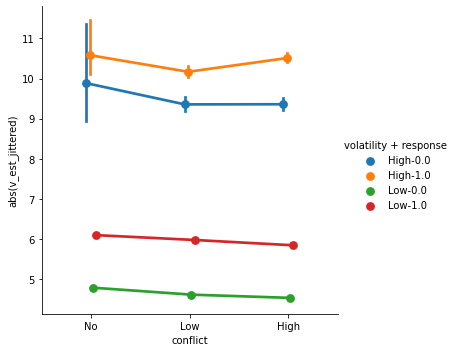

In [64]:
g5 = sns.catplot(x="conflict",y='abs(v_est_jittered)',data=all_rts_vs_drift,hue="volatility + response",kind='point',dodge=True,order=["No","Low","High"])
g5.savefig(figure_dir+"abs_v_est_jittered_all_response_wise.png")